In [18]:
# load C4dynamics
## 
exec(open('importc4d.py').read())

tic()
#
# https://github.com/elbazam/multi_object_tracking
##
import numpy as np
import cv2
from sklearn.neighbors import NearestNeighbors
# %matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from enum import Enum
# import pandas as pd 

#
# config pyplot
##
import matplotlib.ticker as ticker

plt.rcParams["font.family"] = 'Times New Roman' # "Britannic Bold" # "Modern Love"#  "Corbel Bold"# 
plt.rcParams["font.size"]   = 20
# plt.rcParams["font.weight"] = 'bold'

plt.style.use('dark_background')  

plt.rcParams['figure.figsize'] = (9.0, 6.0) 
plt.rcParams['image.interpolation'] = 'nearest'
# plt.ion()



In [19]:
# user input
##
videoname =    'b1b_rok_japan'  #'usmc_xq_58a' # 'carrier_truman' #    'tank_short' # 'cars1'  #'tank_race' #   'cars2' #   'F-16_Takeoff'    #   
detectortype = 'tf'  #  'opencv' #  

t_start = 0 # 30
tf = 0.001  # 2 #      .08 #     
    
#    
# initial settings 
##
outfol = os.path.join(os.getcwd(), 'examples', 'out', detectortype)
if not os.path.exists(outfol):
    os.makedirs(outfol)

videoin  = os.path.join(os.getcwd(), 'examples', 'resources', videoname + '.mp4')
videoout = os.path.join(outfol, videoname + '.mp4')    

In [20]:
# cvideo preprocessing 
#
# initializes video-related parameters such as the frame rate (dt), 
# and retrieves the first frame to determine the video's width and height.
# 
# In OpenCV, CAP_PROP stands for "Capture Property," and it is used to access and modify various properties of a video capture object, typically representing a camera or a video file. These properties allow you to control and retrieve information about the video stream or the camera settings. 

# CAP_PROP is typically followed by a specific property constant that defines the property you want to access or modify. For example, CAP_PROP_FRAME_WIDTH and CAP_PROP_FRAME_HEIGHT are used to set or get the width and height of the frames in the video stream, respectively.

# Here are some common CAP_PROP constants in OpenCV:

# - CAP_PROP_FRAME_WIDTH: Width of the frames in the video stream.
# - CAP_PROP_FRAME_HEIGHT: Height of the frames in the video stream.
# - CAP_PROP_FPS: Frames per second (FPS) of the video stream.
# - CAP_PROP_FOURCC: FourCC code representing the codec of the video stream.
# - CAP_PROP_POS_MSEC: Current position in milliseconds in the video stream.
# - CAP_PROP_POS_FRAMES: Current frame index in the video stream.
# - CAP_PROP_BRIGHTNESS: Brightness setting of the camera.
# - CAP_PROP_CONTRAST: Contrast setting of the camera.
# - CAP_PROP_SATURATION: Saturation setting of the camera.
# - CAP_PROP_HUE: Hue setting of the camera.
# - CAP_PROP_GAIN: Gain setting of the camera.
# - CAP_PROP_EXPOSURE: Exposure setting of the camera.
# - CAP_PROP_AUTOFOCUS: Indicates whether autofocus is enabled.

# You can use these properties with OpenCV functions like VideoCapture::get() and VideoCapture::set() to retrieve and set the corresponding properties of a video capture object. For example:

# python
# import cv2

# # Open a video capture object
# cap = cv2.VideoCapture(0)

# # Get the frame width and height
# frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
# frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

# # Set the frame width and height
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# 

# In the example above, cv2.CAP_PROP_FRAME_WIDTH and cv2.CAP_PROP_FRAME_HEIGHT are used to retrieve and set the width and height of the frames in the video stream.

##

def openvideo():
    cvideo       = cv2.VideoCapture(videoin)
    dt          = 1 / cvideo.get(cv2.CAP_PROP_FPS) # 1 / frame per second = the length of a single frame
    Nframes     = int(cvideo.get(cv2.CAP_PROP_FRAME_COUNT)) # total frames count 
    tf_video    = Nframes * dt 

    fwidth  = int(cvideo.get(cv2.CAP_PROP_FRAME_WIDTH))
    fheight = int(cvideo.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_out  = cv2.VideoWriter(videoout, cv2.VideoWriter_fourcc(*'mp4v')
                    , int(cvideo.get(cv2.CAP_PROP_FPS)), [fwidth, fheight])

    return cvideo, video_out, tf_video, fwidth, fheight, dt

cvideo, cvideo_out, tf_video, fwidth, fheight, dt = openvideo()



In [22]:
# load model with tf framework 
if detectortype == 'tf':
    from tensorflow.keras.models import load_model
    modelpath = os.path.join(os.getcwd(), 'src', 'main', 'resources'
                             , 'detectors', 'yolo', 'v3', 'tensorflow')
    yolomodel = load_model(modelpath, compile = False)

In [23]:
# yolo opencv
import os
import cv2
import numpy as np


MODEL_SIZE           = (416, 416, 3)
CONFIDENCE_THRESHOLD = 0.5
NMS_THRESHOLD        = 0.5 # .3

class yolo_opencv:
    

    def __init__(self):

        weights_path = os.path.join(os.getcwd(), 'src', 'main', 'resources', 'detectors', 'yolo', 'v3', 'yolov3.weights')
        cfg_path     = os.path.join(os.getcwd(), 'src', 'main', 'resources', 'detectors', 'yolo', 'v3', 'yolov3.cfg')
        coconames    = os.path.join(os.getcwd(), 'src', 'main', 'resources', 'detectors', 'yolo', 'v3', 'coco.names')

        self.net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
        self.net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        ln = self.net.getLayerNames()
        self.ln = [ln[i - 1] for i in self.net.getUnconnectedOutLayers()]
                                              
        with open(coconames, 'r') as f:
            self.class_names = f.read().strip().split('\n')

        # self.confidence_threshold = CONFIDENCE_THRESHOLD
        # self.nms_threshold = NMS_THRESHOLD

    #     self.net_width, self.net_height = self.get_net_input_size(cfg_path)
            
    # def get_net_input_size(self, cfg_path):
    #     net_width, net_height = None, None
    #     with open(cfg_path, 'r') as f:
    #         lines = f.read().split('\n')
    #         for line in lines:
    #             if line.startswith("width="):
    #                 net_width = int(line.split('=')[1])
    #             if line.startswith("height="):
    #                 net_height = int(line.split('=')[1])
                    
    #     return net_width, net_height


    
    def measure(self, frame, t, outfile):

        #
        # Step 1: Preprocess the Frame
        #   - Create a blob (binary large object) from the input frame with the specified dimensions
        #   - Normalize pixel values to a range of 0 to 1
        #   - Specify the dimensions of the input layer of the YOLO model
        #   - Swap Red and Blue channels (BGR to RGB)
        #   - Set crop to False to preserve the original aspect ratio
        ##
        # blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB = True, crop = False)
        # blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (self.net_width, self.net_height), swapRB = True, crop = False)
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (MODEL_SIZE[0], MODEL_SIZE[1]), swapRB = True, crop = False)

        #
        # Step 2: Set Input to the YOLO Model and Perform Forward Pass
        #   - Set the blob as the input to the YOLO model
        #   - Get the names of the output layers of the model
        #   - Perform a forward pass through the model to obtain detections
        ##
        self.net.setInput(blob)
        # layer_names = self.net.getUnconnectedOutLayersNames()
        detections = self.net.forward(self.ln) # layer_names)
        
        # if outfile is not None: 
        #     # if 0 < t and t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             file.write(f't: \t {t} \n')
        #             file.write(f'input image:  \t {frame.shape} \n\n')
        #             file.write(f'{frame[:3, :3, :3]} \n\n')

        #             file.write(f'detections number: \t {detections.shape} \n')
        #             file.write('\t center x, center y, width, height, confidence \n')
        #             # for i in range(5):
        #                 # s = np.array2string(detections[0, i, :4], precision = 1)
        #             file.write(f'\t {detections[:5, :5]} \n') # first 5 rows of datapoint and coordinates. 


        #
        # Step 3: Extract Detected Objects
        #   - Iterate through the detected objects in the forward pass results
        #   - Filter objects based on confidence threshold
        #   - Calculate bounding box coordinates and convert to integers
        #   - Append bounding box coordinates and class labels to respective lists
        ##
        # frame_height, frame_width = frame.shape[:2]
        # boxes = []
        # class_labels = []
        
        # for detection in detections:
        #     for obj in detection:
        #         if obj[4] > self.confidence_threshold:
        #             # bounding box:
        #             center_x, center_y, width, height = obj[:4]
        #             top_left_x = center_x - width / 2.0
        #             top_left_y = center_y - height / 2.0
        #             bottom_right_x = center_x + width / 2.0
        #             bottom_right_y = center_y + height / 2.0

        #             boxes.append(np.array([top_left_x, top_left_y, bottom_right_x, bottom_right_y]))
        #             # classification:
        #             class_labels.append(self.class_names[np.argmax(obj[5:])])


        # Extract bounding boxes and confidence scores
        boxes = []
        confidences = []
        classIDs = []
        h, w = frame.shape[:2]



        for detection in detections:
            for d in detection:
                
                scores = d[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                if scores[classID] > CONFIDENCE_THRESHOLD:  # Adjust the confidence threshold as needed

                    box = d[:4] * np.array([w, h, w, h])
                    (center_x, center_y, width, height) = box.astype('int')

                    x = int(center_x - (width / 2)) # left edge 
                    y = int(center_y - (height / 2)) # top edge 

                    boxes.append([x, y, int(width), int(height)]) # top left x, top left y, width, height
                    confidences.append(float(confidence))
                    classIDs.append(classID)        

        indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
        
        box_out = []
        class_out = []

        if len(indices) > 0:
            for i in indices.flatten():
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                box_out.append([x, y, x + w, y + h])
                class_out.append(self.class_names[classIDs[i]])
        box_out = np.array(box_out)
        

        # box_out = np.array(boxes[indices.item()]).reshape(-1, 4)

        # class_out = self.class_names[classIDs[indices.item()]]

        # if len(indices) > 0:
        #     for i in indices.flatten():
        #         (x, y) = (boxes[i][0], boxes[i][1])
        #         (w, h) = (boxes[i][2], boxes[i][3])
        #         box_out.append([x, y, x + w, y + h])    # top left x, top left y, width, height
        #         class_out.append(self.class_names[classIDs[i]])

    




        # if outfile is not None: 
        #     # if 0 < t and t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             file.write(f'box: {box.shape}\n')
        #             file.write(f'{box} \n\n')



        # selected_indices = cv2.dnn.NMSBoxes(boxes, confidence, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)


        # # Filter the bounding boxes based on NMS results
        # filtered_boxes = [boxes[i[0]] for i in selected_indices]
        # filtered_scores = [scores[i[0]] for i in selected_indices]


        # # Process the filtered bounding boxes and scores as needed
        # for box, score in zip(filtered_boxes, filtered_scores):
        #     x, y, w, h = box
        #     left, top, right, bottom = int(x - w/2), int(y - h/2), int(x + w/2), int(y + h/2)
        #     # cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        #     # label = f"Confidence: {score:.2f}"
        #     # cv2.putText(frame, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


        # boxes = np.array(boxes)



        # if outfile is not None:
        #     if t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             file.write(f't: {t}\n')
        #             file.write(f'boxes:\n\t{boxes}\n\n')
        #             file.write(f'classifications:\n\t{class_labels}\n')

        # top left, top right, width, height 
        # center_x, center_y, width, height = ( * np.array([frame_width, frame_height, frame_width, frame_height])).astype(int)
        
        # x, y = center_x - width // 2, center_y - height // 2
        
        # boxes.append([x, y, width, height])
        
        return box_out, class_out


In [24]:
# yolo tf
# from tensorflow.keras.models import load_model
from tensorflow import image, expand_dims,  split, reshape, shape, concat
from tensorflow.image import combined_non_max_suppression

# https://saturncloud.io/blog/how-to-resolve-python-kernel-dies-on-jupyter-notebook-with-tensorflow-2/
# from .detector_utils import * 
import numpy as np
import os


MODEL_SIZE                = (416, 416, 3)
NUM_OF_CLASSES            = 80
MAX_OUTPUT_SIZE           = 40
MAX_OUTPUT_SIZE_PER_CLASS = 20
IOU_THRESHOLD             = 0.5
CONFIDENCE_THRESHOLD      = 0.5


class yolo_tf():
    
    '''
    The yolo_detector class is a wrapper for object detection using the YOLO 
    (You Only Look Once) model. 

    1. __init__(self, height=0, width=0): 
        The class constructor initializes the YOLO model by loading it 
        from the specified model path. 
        It also loads the class names for the detected objects. 
        The height and width parameters are used to set the dimensions of the video frame.

    2. measure(self, frame): 
        This method takes a frame as input and performs object detection 
        on it using the YOLO model. 
        It returns the bounding box coordinates of the detected objects 
        scaled according to the frame dimensions.

        performs the actual object detection on the given frame. 
        It preprocesses the frame, resizes it to match the model's input size, 
        and passes it through the YOLO model to obtain the bounding box coordinates, 
        scores, class predictions, and the number of detected objects.




    The yolo_detector class encapsulates the functionality of object detection using the YOLO model, 
    providing methods to perform detection, extract measurements, 
    and visualize the results on the frame. The class works in conjunction 
    with the YOLO model, which is loaded externally and used for the actual detection process.


    '''
    
    
    def __init__(self, height = 0, width = 0):
        # modelpath = os.path.join(os.getcwd(), 'src', 'main', 'resources', 'detectors', 'yolo_darknet')
        # self.model = load_model(modelpath, compile = False)
        self.model = yolomodel

        with open(os.path.join(os.getcwd(), 'src', 'main', 'resources', 'detectors', 'yolo', 'v3', 'coco.names'), 'r') as f:
            self.class_names = f.read().splitlines()

        self.width = width
        self.height = height


    def measure(self, frame, t, outfile):
        
        resized_frame = expand_dims(frame, 0)
        resized_frame = image.resize(resized_frame, (MODEL_SIZE[0], MODEL_SIZE[1]))
        
        detections = self.model.predict(resized_frame, verbose = 0).squeeze()
        # detections shape: (1, 10647, 85)
        dtctinx = -np.partition(-detections, 5, axis = 0)[:5, :]

        # center_x, center_y, width, height, confidence, classes = split(detections, [1, 1, 1, 1, 1, -1], axis = -1) # all the rest enter to classes. split along the alst axis. 
        


        
        # log
        # number of raw detections
        # datapoints of raw detections 
        # + type
        if outfile is not None: 
            # if 0 < t and t < 0.05: # one frame 
                with open(outfile, 'at') as file:
                    file.write(f't: \t {t} \n')
                    file.write(f'input image:  \t {resized_frame.shape} \n\n')
                    file.write(f'{resized_frame[0, :3, :3, :3]} \n\n')

                    file.write(f'detections number: \t {detections.shape} \n')
                    file.write('\t center x, center y, width, height, confidence \n')
                    # for i in range(5):
                        # s = np.array2string(detections[i, :4], precision = 1)
                    file.write(f'{detections[:5, :5]} \n\n') # first 5 rows of datapoint and coordinates. 
                    file.write(f'top 5 confident: \n') # first 5 rows of datapoint and coordinates. 
                    file.write(f'{dtctinx[np.argsort(dtctinx[:, 5])[::-1], :5]} \n') # first 5 rows of datapoint and coordinates. 
                    # file.write(f'\t {np.array2string(dtctinx[:, :5], precision = 0)} \n') # first 5 rows of datapoint and coordinates. 
                    file.write('\n')
        # measurement


        # top_left_x = center_x - width / 2.0
        # top_left_y = center_y - height / 2.0

        # bottom_right_x = center_x + width / 2.0
        # bottom_right_y = center_y + height / 2.0


        xcenter = detections[:, 0].copy()
        # top_left_x = center_x - width / 2.0
        detections[:, 0] = xcenter - detections[:, 2] / 2.0  # top_left_x        
        # bottom_right_x = center_x + width / 2.0
        detections[:, 2] = xcenter + detections[:, 2] / 2.0  # bottom_right_x
        ycenter = detections[:, 1].copy()
        # top_left_y = center_y - height / 2.0
        detections[:, 1] = ycenter - detections[:, 3] / 2.0  # top_left_y
        # bottom_right_y = center_y + height / 2.0
        detections[:, 3] = ycenter + detections[:, 3] / 2.0  # bottom_right_y





        # log
        # normalized datapoints
        # + type
        # score, confidence. 

        # detections = concat([top_left_x, top_left_y, bottom_right_x, bottom_right_y, confidence, classes], axis = -1)
        
        bbox, confs, class_probs = split(detections, [4, 1, -1], axis = -1)
        bbox = bbox / MODEL_SIZE[0]
        scores = confs * class_probs
        # log
        # box coordinates
        # + type
        if outfile is not None: 
            # if 0 < t and t < 0.05: # one frame 
                with open(outfile, 'at') as file:
                    file.write(f'bbox: {bbox.shape}\n')
                    file.write(f'{bbox[:2, :]} \n\n')

        # print('zzz')
        #
        # combined_non_max_suppression() in TensorFlow's Object Detection 
        #   API has the following signature:
        # 
        # (nmsed_boxes, 
        #   nmsed_scores, 
        #   nmsed_classes, 
        #   valid_detections)
        #       = tf.image.combined_non_max_suppression(
        #           boxes,
        #           scores,
        #           max_output_size_per_class,
        #           max_total_size,
        #           iou_threshold,
        #           score_threshold,
        #           pad_to_max_output_size=True)
        # 
        # input args: 
        #   1. boxes: A 2D float tensor with shape [batch_size, num_boxes, 1, 4] where boxesis the 
        #           number of bounding boxes. 
        #           Each row corresponds to a bounding box, and the columns represent the box 
        #           coordinates (x1, y1, x2, y2).
        #   2. scores: A 1D float tensor with shape [num_boxes] containing the confidence 
        #           scores associated with each bounding box.
        #   3. x_output_size_per_classAn integer specifying the maximum number of retained 
        #           boxes per class. It limits the number of boxes retained for each class.
        #   4. max_total_sizen integer specifying the maximum total number of boxes to be 
        #           retained across all classes. This argument limits the total number of boxes 
        #           retained after NMS, regardless of their classes.
        #   5. iou_threshold: A float value representing the intersection-over-union (IOU) threshold. 
        #           Boxes with IOU values higher than this threshold are considered duplicates, 
        #           and NMS keeps the one with the highest confidence score.
        #   6. score_threshold: A float value specifying the confidence score threshold. Boxes with 
        #           confidence scores below this threshold are discarded.
        #   7. pad_to_max_output_size: A boolean flag indicating whether to pad the output boxes to 
        #           the specified max_total_size. If set to True the output will be padded to ensure 
        #           that the total number of boxes is at least ax_total_size even if some of the boxes 
        #           have confidence scores below the threshold.
        # 
        # output args:
        #   1. msed_boxes2D: float tensor representing the coordinates of the non-maximum suppressed 
        #           bounding boxes. It has the shape [batch_size, max_total_size, 4], where batch_size 
        #           is the number of batches, and max_total_sizes the specified maximum total number 
        #           of retained boxes. Each row corresponds to a bounding box, and the columns represent 
        #           the box coordinates (x1, y1, x2, y2).
        #   2. nmsed_scores: A 1D float tensor containing the confidence scores associated with the 
        #           non-maximum suppressed boxes. It has the shape batch_size, max_total_size].
        #   3. nmsed_classes: A 1D int tensor representing the class IDs associated with the non-maximum 
        #           suppressed boxes. It has the shape [batch_size, max_total_size].
        #   4. valid_detections: A 1D int tensor that indicates the number of valid (retained) detections 
        #           for each batch. It has the shape [batch_size]. This tensor is useful for tracking the 
        #           number of detections for each batch, which may vary.
        ##
        # print(f'box shape: {bbox.shape}')
        # print(f'scores shape: {scores.shape}')
        # print(f'confs shape: {confs.shape}')

        # print(reshape(bbox, (1, -1, 1, 4)).shape)
        # print(reshape(scores, (shape(scores)[0], -1, shape(scores)[-1])).shape)

        # # print(expand_dims(bbox, expand_dims(bbox, axis = [0, -1]) ).shape)
        # print(expand_dims(scores, axis = 0).shape)
        
        boxes, _, _, Nvalid = combined_non_max_suppression(
                            boxes = reshape(bbox, (1, -1, 1, 4)) # reshapedbox 
                                , scores = expand_dims(scores, axis = 0)  # reshape(scores, (1, -1, 1, 4)) # reshape(scores, (shape(scores)[0], -1, shape(scores)[-1]))
                                    , max_output_size_per_class = MAX_OUTPUT_SIZE_PER_CLASS
                                        , max_total_size = MAX_OUTPUT_SIZE
                                            , iou_threshold = IOU_THRESHOLD
                                                , score_threshold = CONFIDENCE_THRESHOLD)
        # log
        # number of boxes after suppression
        # coordinates
        # + type
        # if outfile is not None: 
        #     # if 0 < t and t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             # file.write(f'boxes: {reshapedbox.shape}\n')
        #             file.write(f'{reshapedbox[:2, :2, :]} \n\n')

        # Extract class indices with highest confidence
        class_indices = np.argmax(class_probs, axis = -1)

        # Extract class labels using the class_indices and class_names
        class_labels = [self.class_names[i] for i in class_indices]

        # if outfile is not None: 
        #     # if 0 < t and t < 0.05: # one frame 
        #     with open(outfile, 'at') as file:
        #         file.write(f'N after suppression: \t {boxes.shape} \t nums = {Nvalid} \n')
        #         file.write(f'normalized datapoints: + class \n')
        #         for i in range(5):
        #             file.write(f'\t {bbox[i, :4]} \t {class_labels[i]} \n') # first 5 rows of datapoint and coordinates. 
        #         file.write(f' \n')


        # if outfile is not None: 
        #     if 0 < t and t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             file.write(f'normalized datapoints: + scores \n')
        #             for i in range(5):
        #                 file.write(f'\t {bbox[0, i, :4]} \t {scores[i]} \n') # first 5 rows of datapoint and coordinates. 




        N = Nvalid[0].numpy()
        boxout = boxes[0][:N].numpy()
        
        # 
        # translate the normalized diagnonal of the bounding box to the size of the recorded frame:
        ## 
        boxout[:, [0, 2]] *= self.width # x1
        # boxout[:, 2] = boxout[:, 2] * self.width # x2
        
        boxout[:, [1, 3]] *= self.height # y1 
        # boxout[:, 3] = boxout[:, 3] * self.height # y2 
        # log
        # normalized box out coordinates 
        
        # Return both bounding boxes and object classifications
        return boxout, class_labels[:N]
        


In [25]:
# initializes the object detector (Yolo Detector). 
# passing the video's height and width.

if detectortype == 'tf':
    # atching_modules = [module_name for module_name in sys.modules]
    # for module_name in matching_modules:
    #     print(module_name)
    #     # del sys.modules[module_name]
    if False: 
        import importlib, C4dynamics
        importlib.reload(C4dynamics.src.main.py.detectors.yolo_tf)
        from C4dynamics.src.main.py.detectors.yolo_tf import yolo as yolo
        yolodet = yolo(yolomodel, height = fheight, width = fwidth)
    else:
        yolodet = yolo_tf(height = fheight, width = fwidth)

elif detectortype == 'opencv':
    yolodet = c4d.detectors.yolo_opencv()
    # yolodet = yolo_opencv()
else:
    yolodet = None


In [26]:
# plt.imshow(mpimg.imread(os.path.join(os.getcwd(), 'examples', 'out', 'before.png')))
# plt.axis('off')
# plt.show()

In [27]:
# x(t) = A(t) * x(t-1) + e(t) || e(t) ~ N(0,Q(t))
# z(t) = H(t) * x(t) + r(t)   || r(t) ~ N(0,R(t))

# x(t) = [x1 y1 x2 y2 vx vy]

A = np.array([[1, 0, 0, 0, dt, 0 ]
            , [0, 1, 0, 0, 0,  dt]
            , [0, 0, 1, 0, dt, 0 ]
            , [0, 0, 0, 1, 0,  dt]
            , [0, 0, 0, 0, 1,  0 ]
            , [0, 0, 0, 0, 0,  1 ]])

H = np.array([[1, 0, 0, 0, 0, 0]
            , [0, 1, 0, 0, 0, 0]
            , [0, 0, 1, 0, 0, 0]
            , [0, 0, 0, 1, 0, 0]])

P = np.eye(A.shape[1])

Q = np.array([[25, 0,  0,  0,  0,  0]
            , [0,  25, 0,  0,  0,  0]
            , [0,  0,  25, 0,  0,  0]
            , [0,  0,  0,  25, 0,  0]
            , [0,  0,  0,  0,  49, 0]
            , [0,  0,  0,  0,  0,  49]])

R = dt * np.eye(4)


In [28]:
class trkstate(Enum):
    CLOSED      = 0
    PREDICTED   = 1
    CORRECTED   = 2


    
class tracker(c4d.datapoint):
    ''' 
        TODO 
        1) a tracker object is actually a 2 datapoints object
        2) reconsider the kalman filter. it is maybe not required for eqch tracker to hold one.
            but the kalman holds the state (why if it is hold ny the dp?)

        3) other option the object is a single dp with height & width att's.
        4) then the measure as kalman update should be changed to a center only and the matrices be modified as well.
    '''
    
    # a datapoint 
    # kalman filter 
    # display color
    ## 
    
    def __init__(obj, z): # , measure_id, t):

        super().__init__()  # Call the constructor of c4d.datapoint
         
        # initialize the state with direct substitution of the meausre 
        obj.filter = c4d.filters.kalman(np.hstack((z, np.zeros(2))), P, A, H, Q, R)
        
        obj.state = trkstate.PREDICTED
        obj.appear = 0
        obj.counterSame = 0
        obj.counterEscaped = 0

        obj.color = np.random.randint(0, 255, size = 3).tolist()

        # obj.measure_id = -1 # [t, measure_id



    def isvalid(obj, measure):
        # 
        # confirm valid measure for state correction 
        ## 

        if len(measure) == 0:
            return False  
        elif obj.appear < 8:
            return True
        
        #
        # otherwise, innovation test
        #   assess whether a new measurement is consistent with the filter's state estimate
        ## 

        # difference between the actual measurement (measure) and the predicted measurement
        innovation = measure - np.dot(obj.filter.H, obj.filter.x)
        # innovation covariance matrix (propagates the error covariance matrix P through the measurement matrix H + noise covariance matrix R)
        S = np.dot(obj.filter.H, np.dot(obj.filter.P, obj.filter.H.T)) + obj.filter.R
        # Mahalanobis distance squared (epsilon). 
        #   quantify how many standard deviations the innovation is away from the expected value 
        #   based on the covariance matrix S. 
        # use the inverse of S to normalize the innovation vector and make it comparable.
        epsilon = np.dot(innovation.T, np.dot(np.linalg.inv(S), innovation))

        return epsilon < 9.488 # chi
        
        


    
    def position(obj):
        # kalman states:
        #   x(t) = [x1 y1 x2 y2 vx vy]
        # then x[:4] are the center coords.
        ##
        return np.array(obj.filter.x[:4].astype(np.int32))


    def getvelocity(obj):
        # kalman states:
        #   x(t) = [x1 y1 x2 y2 vx vy]
        # then x[4:] are the velocity coords.
        ## 
        return obj.filter.x[4:].astype(np.int32)


    def getcenter(obj):
        center = np.zeros(2)
        state = obj.position()
        center[0] = 0.5 * (state[0] + state[2])
        center[1] = 0.5 * (state[1] + state[3])
        return center.astype(np.int32)



    def duplicated(obj):
        obj.counterSame += 1
        if obj.counterSame > 3:
            return True
        return False
    


    def advance(obj, corrected):

        if corrected:
            obj.counterEscaped = 0
            obj.appear += 1
            obj.state = trkstate.CORRECTED
        else:
            obj.counterEscaped += 1

            if obj.counterEscaped > 40:
                obj.state = trkstate.CLOSED
            else:
                obj.state = trkstate.PREDICTED

            
    
    
    def __eq__(obj, other):
        x1 = obj.position()
        x2 = other.position()
        if np.linalg.norm(x1 - x2) < 10: 
            return True 

In [29]:
# trackers manager:
#   list of active trackers
#   add or remove tracks methods
class mTracks:
    #
    # this class shouldnt belong to this project notebook but to the body module of c4d.
    # theres also should be a saperation between the objects detecton processing and the objects bank handling. 
    # however this class cannot currently be introduced as is to c4dyanmics as it doesnt handle body objects but handles tracks
    # which is another class of this nb. 
    ## 
    
    def __init__(obj):
        obj.trackers = {}
        # obj.removelist = []
        obj.neigh = NearestNeighbors(n_neighbors = 1)
        # threshold of 100 pixels to verify the measure is close enough to the object. 
        obj.thresh = 100 

        #
        # for debug only
        ##
        obj.measurecnt = 0
        obj.zdList = np.empty((0, 6))
        # obj.trk_df = pd.DataFrame(columns = ['R1', 'R2', 'R3'])

        obj.cov = 25 * np.eye(4) 


    def add(obj, key, z):#, measure_id):
        obj.trackers[key] = tracker(z)
    

    def trackerMaker(obj, zList, t):
        # 
        # updates the existing trackers based on a list of new observations zList. 
        # uses the Nearest Neighbors algorithm to find the nearest observation for each tracker, 
        # associates them, and then creates new trackers for any unassociated observations.
        ## 
        RestOfZ = np.copy(zList)

        check = NearestNeighbors(n_neighbors = 1)
        # fits the nearest neighbors model (check) with the data in zList. 
        #   prepares the model for nearest neighbor searches in the zList. 
        check.fit(zList)

        AssociatedZ = [] # an empty list to store associated data points.
        delist      = []
        
        for trk in obj.trackers.values():
            
            _, idx = check.kneighbors([trk.position()]) # uses the previously created nearest neighbors model to find the index of the nearest neighbor to the kfPose in the zList
            
            if idx[0][0] not in delist:
                # If the found index of the nearest data point is not already in the delist, 
                #   (the data point hasn't been associated with any other tracker), 
                #   it is considered an association with the current object tracker. 
                #   This data point is then appended to the AssociatedZ list.
                ## 
                AssociatedZ.append(zList[idx[0][0]])
                delist.append(idx[0][0])
                
                

        # AssociatedZ contains the data points from zList that are currently associated 
        #   with the object trackers in the loop. 
        # This list will be used for further processing or analysis related to the object tracking system.
        AssociatedZ = np.array(AssociatedZ)


        RestOfZ = np.delete(RestOfZ, delist, 0)
        
        if list(obj.trackers.keys()):
            # If there are keys in obj.trackers, calculate the next available key for a new tracker, 
            #   ensuring there are no duplicates.
            lastKey = list(obj.trackers.keys())[-1] + 1
            while lastKey in list(obj.trackers.keys()):
                lastKey += 1
        else:
            lastKey = 0
            
        RestOfZSize = AssociatedZ.shape[0] # calculate the size of the remaining data points in AssociatedZ and store it.
        
        if RestOfZSize > 0 and not lastKey == 0:
            # If there are data points in RestOfZ and the last key is not 0, 
            #   fit the nearest neighbors model 'check' with the AssociatedZ.
            check.fit(AssociatedZ)
            
        UpdateTracker = True
        n = zList.shape[1]
        
        
        for z in RestOfZ:
            # iterate over the remaining data points in RestOfZ.
            if not lastKey == 0 and RestOfZSize > 0:
                
                UpdateTracker = False
                _, idx = check.kneighbors([z])
                v = z - AssociatedZ[idx[0][0]]
                epsilon = np.dot(v.T, np.dot(np.linalg.inv(obj.cov), v))
                # set the UpdateTracker based on certain conditions involving the Kalman Filter's error.
                if (n == 2 and not epsilon < 5.991) or (n == 4 and not epsilon < 9.448): 
                    UpdateTracker = True
                # elif n == 4 and not epsilon < 9.448: 
                #     UpdateTracker = True
            
            if UpdateTracker:
                print(f'{t:.2f}s: new track: {lastKey}')
                obj.add(lastKey, z)# , measure_id) #1 track creation 
                lastKey += 1
                UpdateTracker = False

        
    def refresh(obj, zList, frame, t, zarray, outfile):
        # updates the state of each tracker:
        #   - Performs measurements handling. \\ isnt the meausre performed in the main? \\ 
        #   - Associates trk id by a nearest neighbor.
        #   - Visualizes the tracked objects on the frame.
        ## 
        for key, trk in obj.trackers.items():
            if trk.state == trkstate.CLOSED:
                continue

            #
            # three options for the trk state in the end of this procedure:
            #   CORRECTED:      if conditions for correct are satisfied
            #   PREDICTED:      if conditions for correct are'nt satisfied
            #   CLOSED:         if counterEscaped exceed threshold 
            ##

            # 
            # predict
            # reason to do prediction always before the correct stage:
            #   1) the measure doesnt update all the variables in the state 
            #   2) the correct is based on the previous state and only makes a correction to it by:
            #       x = x + K @ y
            #      the same is true also for the covariance matrix. 
            #   3) it fill the gaps when the measurement is not valid for correcting the state. 
            ##
            obj.trackers[key].filter.predict()


            # 
            # prepare for the correct stage 
            ##

            measurement = []

            if zList.shape[0] == 1: # one row
            # if zarray.shape[0] == 1: 
                #
                # if exactly one measure exists, no need to check which is closest 
                # how it knows that it belongs to this track? 
                ##
                measurement = zList[0]
                # measurement = zarray[:4, ]
                # measure_id = zarray[4]

            elif zList.shape[0] >= 2:
                #
                # if more than one measure, check which is the closest. 
                # 
                # what's the vlaue of doing predict in a phase of correct? perhaps it was there to predict the next posoition for comparison with the input measures. 
                ##

                # 
                # d: Distances Array 
                #   This array contains the distances between each sample and its k-nearest neighbors.
                #   Each row corresponds to a sample, and the values in that row represent the distances to its 
                #   k-nearest neighbors.
                # 
                # relativeIndex: Indices Array
                #   This array contains the indices of the k-nearest neighbors for each sample. 
                #   Each row in the array corresponds to a sample in the dataset, and the values 
                #   in that row represent the indices of its k-nearest neighbors in the dataset.
                ##  
                d, relativeIndex = obj.neigh.kneighbors(obj.trackers[key].position()[np.newaxis, :])
                
                # as we query one element with 1 neighbor it's possible to extract the results with item():
                if d.item() < obj.thresh:
                    # pretty close 

                    
                    z = zList[relativeIndex.flatten()] # np.array()
                    # z = zarray[relativeIndex[0], :4] 
                    # measure_id = zarray[relativeIndex.item(), 4]

                    if len(z) == 1: # # i dont understand how kneighbors() can return more than 1 if we alwasy introduce one track's position. 
                        measurement = z[0]
                    else:
                        npDistances = d.flatten() # reduce a single order. 
                        npDistances = npDistances * npDistances
                        weights = 1 - npDistances / np.sum(npDistances)
                        # return np.average(z, weights = weights, axis = 0)
                        measurement = np.average(z, weights = weights, axis = 0)
                    




            corrected = obj.trackers[key].isvalid(measurement)


            # if len(measurement) == 0:
            #     corrected = False 
            # else:
            #     innovation = measurement - np.dot(obj.trackers[key].filter.H, obj.trackers[key].filter.x)
            #     S = np.dot(obj.trackers[key].filter.H, np.dot(obj.trackers[key].filter.P, obj.trackers[key].filter.H.T)) + obj.trackers[key].filter.R
            #     epsilon = np.dot(innovation.T, np.dot(np.linalg.inv(S), innovation))

            #     if obj.trackers[key].appear < 8:
            #         corrected = True
            #     else: 
            #         corrected = epsilon < 9.488 
                


            # if outfile is not None: 
            #     if t < 0.05: # ne frame 
            #         with open(outfile, 'at') as file:
            #             file.write(f'{t:.2f} \t {np.array2string(measurement, precision = 0)} \n')


            if corrected:
                # 
                # correct 
                ##
                obj.trackers[key].filter.correct(measurement)
                # obj.trakcers[key].measure_id = TBD


            #
            # record trk state, 
            # quit if closed
            ## 
            obj.trackers[key].advance(corrected) 
            if obj.trackers[key].state == trkstate.CLOSED:
                print(f'{t:.2f}s: closing trk {key}')
                continue


            #
            # prepare to present on the frame
            ##

            pose = obj.trackers[key].position()
            vel = obj.trackers[key].getvelocity() * dt
            center = obj.trackers[key].getcenter()
            color = trk.color
            
            obj.trackers[key].x = center[0]
            obj.trackers[key].y = center[1]
            obj.trackers[key].vx = vel[0]
            obj.trackers[key].vy = vel[1]
            

            obj.trackers[key].store(t)
            obj.trackers[key].storevar('state', t)
            # obj.trackers[key].storevar('measure_id', t)

            # if obj.trackers[key].state == trkstate.CORRECTED: 
            cv2.rectangle(frame, (pose[0], pose[1]), (pose[2], pose[3]), color, 2)
            cv2.putText(frame, 'id: ' + str(key), (center + [0, -10]), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
            cv2.arrowedLine(frame, center, center + vel.astype(np.int32), color, 4)
                
    
    def RemoveDoubles(obj, t):
        # more trackers than measurements
        # removes duplicate trackers that are close to each other. 
        # compares trackers and removes duplicates based on a threshold.
        ##

        # keys = list(obj.trackers.keys())
        keys = [key for key, value in obj.trackers.items() if not value.state == trkstate.CLOSED]

        KeysVisited = []
        
        for key in keys:
            for inKey in keys:
                if key == inKey or inKey in KeysVisited:
                    continue
                if obj.trackers[key] == obj.trackers[inKey]:

                    

                    if obj.trackers[inKey].duplicated():
                        obj.trackers[inKey].state = trkstate.CLOSED
                        print('{t:.2f}: closing duplicated trk ' + str(inKey))


            KeysVisited.append(key)
            
        # for inKey in KeysRemove:
        #     print("Removing doubles")
        #     print(f'deleted existing data with key: {inKey}')
        #     try: 
        #         obj.trackers.pop(inKey)
        #     except: 
        #         print('deleted this key before')


In [30]:
def run(tf = tf_video, showmustgoon = True, outfile = None):

    with open(outfile, 'wt') as file:
        file.write(f'')

    mtracks = mTracks()
    
    
    t = 0
    
    while cvideo.isOpened():
        
        ret, frame = cvideo.read()
        # frame = frame.astype(np.uint8)
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Assuming input frames are in BGR format
        
        if not ret: 
            break


        
        #
        # the update function runs the main trackers loop.  
        #
        # retrieves object measurements from the current frame using the object detector (YoloDetector).
        # 
        # the output result is two coordinates for x (left [column 0], and right [column 2]) 
        #   of the bounding box, and two coordinates for y (top [column 1], and bottom (column [3]))
        ##
        zList, z_classes = yolodet.measure(frame, t, outfile) 

        zarray = np.concatenate((zList.reshape(-1, 4)
                                , np.arange(mtracks.measurecnt, mtracks.measurecnt + zList.shape[0])[:, np.newaxis]
                                , np.ones((zList.shape[0], 1)) * t)
                                        , axis = 1)
        mtracks.zdList = np.concatenate((mtracks.zdList, zarray), axis = 0)
        mtracks.measurecnt += zList.shape[0]

        # for z in zList: 
        #     mtracks.zdList[mtracks.measurecnt] = (t, z)
        #     mtracks.measurecnt += 1
        

        # updates the trackers dictionary by adding or removing tracks.  
        # creates new trackers if there are more 
        # measurements than trackers and removes duplicate trackers if 
        # there are more trackers than measurements.
        #
        # TODO 
        # this one should check status not validity: 
        # np.sum([trk.state != trkstate.CLOSED for trk in mtracks.trackers.values()])
        # !
        kfNumber = len(mtracks.trackers.keys())
        zNumber = zList.shape[0]
        
        if kfNumber < zNumber:
            # more measurements than trackers
            mtracks.trackerMaker(zList, t)
            
        elif kfNumber > zNumber and zNumber > 0:
            # more trackers than measurements
            mtracks.RemoveDoubles(t)
        
        
        # fits the Nearest Neighbors algorithm to the object 
        # measurements for association purposes.
        if zList.shape[0] >= 2:
            mtracks.neigh.fit(zList)


        mtracks.refresh(zList, frame, t, None, outfile)
        print(z_classes)
        



        #
        # debug
        ##

        # if t > 0.66 and t <= 0.8:
        #     fol, _ = os.path.split(outfile)
        #     cv2.imwrite(os.path.join(fol, str(round(t, 4)).replace('.', '_') + '.png'), frame)

        # if outfile is not None: 
        #     if t < 0.05: # one frame 
        #         with open(outfile, 'at') as file:
        #             file.write(f'zlist: {len(zList)} \n\n')

        # save the list of raw measures with id and timestamp
        # save the list of trackers with timestamp and associated id. 




        # mtracks.remove()

        if showmustgoon:
            cv2.imshow('image', frame)
            
        cvideo_out.write(frame)
        
        t += dt
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or t > tf:
            break
        
        
    cv2.destroyAllWindows()
    cvideo_out.release()
    return mtracks



In [31]:
tic()

if not cvideo_out.isOpened():
    cvideo, cvideo_out, tf_video, fwidth, fheight, dt = openvideo()

# Tvideo = Nframes * t_start -> Nframes = Tvideo / dt
Nframes = t_start / dt
cvideo.set(cv2.CAP_PROP_POS_FRAMES, Nframes)



ltrk = run(tf = tf, showmustgoon =  False, outfile = os.path.join(outfol, 'debug_' + videoname + '.txt'))

#
# 32/32 [==============================] - 0s 2ms/step
#
# 32/32                                 current batch number
# [==============================]      progress bar
# 0s                                    time elapsed for processing the current batch. 
# 2ms/step                              time taken to process each step (each batch) in milliseconds. 

print('video length: ' + str(tf) + '\n'
        + 'number of detected objects: ' + str(len(ltrk.trackers)) + '\n'
            + 'process time:' + str(round(toc() / 60, 2)) + 'min')
    





0.00s: new track: 0
['person', 'person', 'person']
19.47699785232544
video length: 0.001
number of detected objects: 1
process time:0.32min


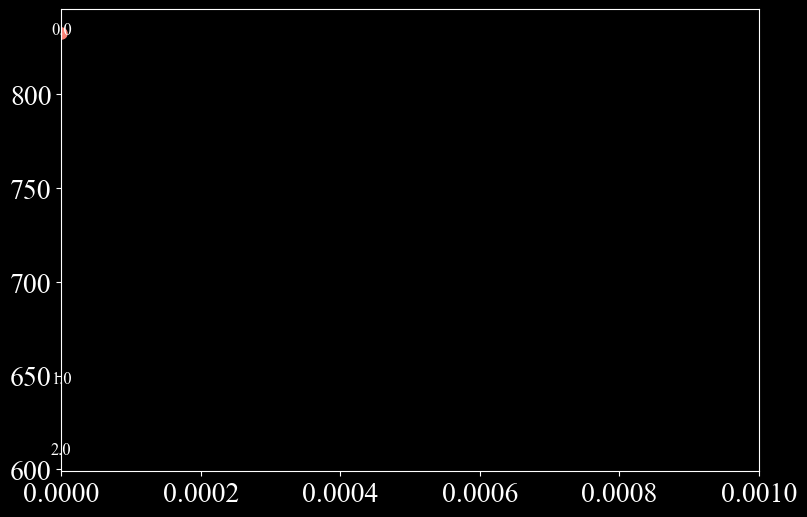

In [32]:
# compare measures to tracks

# for each item in the tracks list, 
#   extract all the meausres associated with it and show them in different colors. 

# generate a dictionary of colors wrt the keys number 
cmap = {}
for m in range(ltrk.measurecnt):
    cmap[m] = np.random.rand(1, 3)

# for zl in ltrk.zdList:
#     print(zl)

fig = plt.figure
ax = plt.subplot(111)

for z in ltrk.zdList:
    # show r of all the detections, 
    # print(z[1])
    measure_id = z[4]
    t = z[5]
    x = 0.5 * (z[0] + z[2])
    y = 0.5 * (z[1] + z[3])
    r = np.sqrt(x**2 + y**2)

    ax.plot(t, r, marker = 'o', markersize = 0) # , color = cmap[z[1]], markersize = 8, linewidth = 0) 
    # print(f't = {t}, measure id = {measure_id}, r = {r}')
    plt.text(t, r, f'{measure_id}', fontsize = 12, ha = 'center', va = 'center')


for k, v in ltrk.trackers.items():

    t = v.get_data('t')
    # m = v.get_data('measure_id')
    r = np.sqrt(v.get_data('x')**2 + v.get_data('y')**2)

    ax.plot(t, r, marker = 'o', markersize = 8, linewidth = 0) # , color = cmap[z[1]]

    # print(f't = {t}, measure id = {measure_id}, r = {r}')
    # plt.text(t, r, f'{m}', fontsize = 12, ha = 'center', va = 'center')

    # ax.plot(t, k * np.ones_like(v.get_data('t')), linewidth = 1)
    # ax.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 

    # ax.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))


    # line = ax1.plot(t, k * np.ones_like(v.get_data('t')), linewidth = 1)
    # ax1.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 
    # ax1.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))

ax.set_xlim(0, tf)


# plt.legend(title = 'trk')
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.7, box.height])
# ax1.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
# ax1.set(xlabel = 'time (sec)',ylabel = '#trk')
# ax1.set_title('Track Number vs Life Time', fontweight = 'bold')
# ax1.grid(alpha = 0.5, axis = 'x')

# plt.show()
# plt.show(block = False)
plt.savefig(os.path.join(outfol, 'detections.jpg'))


(0.0, 0.001)

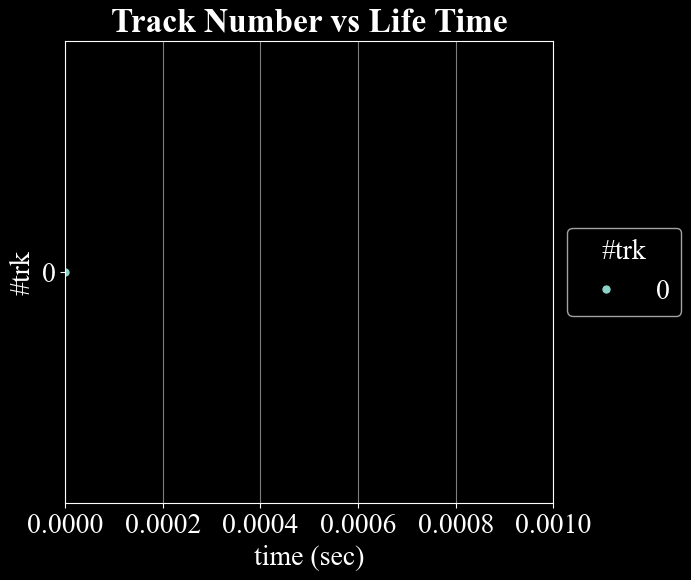

In [33]:
# trks lifetime 

fig1 = plt.figure(1)
ax1  = plt.subplot(111)



for k, v in ltrk.trackers.items():
    vstate = np.vectorize(lambda x: x.value)(v.get_data('state')[:, 1])
    iscorrect = np.where(vstate == trkstate.CORRECTED.value)[0]

    line = ax1.plot(v.get_data('t'), k * np.ones_like(v.get_data('t')), linewidth = 1)
    ax1.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))




plt.legend(title = 'trk')
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.7, box.height])
ax1.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax1.set(xlabel = 'time (sec)',ylabel = '#trk')
ax1.set_title('Track Number vs Life Time', fontweight = 'bold')
ax1.grid(alpha = 0.5, axis = 'x')

ax1.set_xlim(0, tf)



Text(0.5, 1.0, 'Tracks Range')

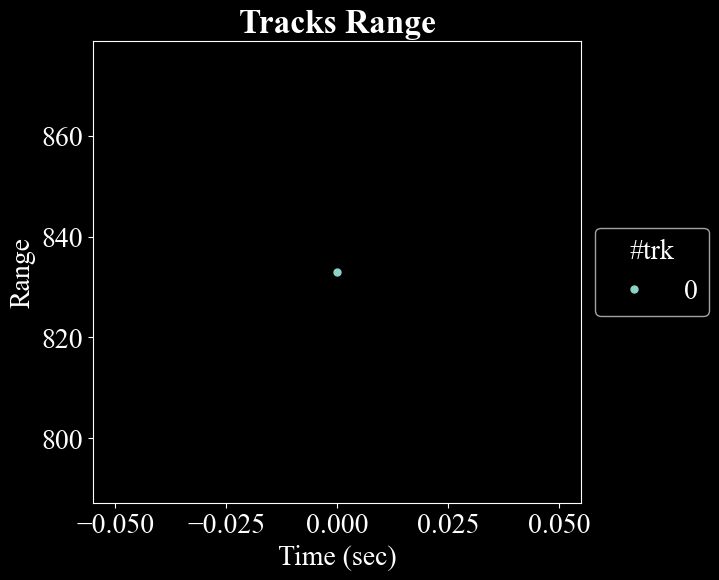

In [34]:
# false positive
# plot range vs time and diff them below thrshold 
##


fig = plt.figure
ax = plt.subplot(111)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))

for k, v in ltrk.trackers.items():

    t = v.get_data('t')
    r = np.sqrt(v.get_data('x')**2 + v.get_data('y')**2)

    vstate = np.vectorize(lambda x: x.value)(v.get_data('state')[:, 1])
    iscorrect = np.where(vstate == trkstate.CORRECTED.value)[0]

    line = ax.plot(t, r, linewidth = 2)
    ax.plot(v.get_data('t')[iscorrect], r[iscorrect], marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 


plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'Time (sec)',ylabel = 'Range')
ax.set_title('Tracks Range', fontweight = 'bold')
# ax.grid(alpha = 0.5, axis = 'x')

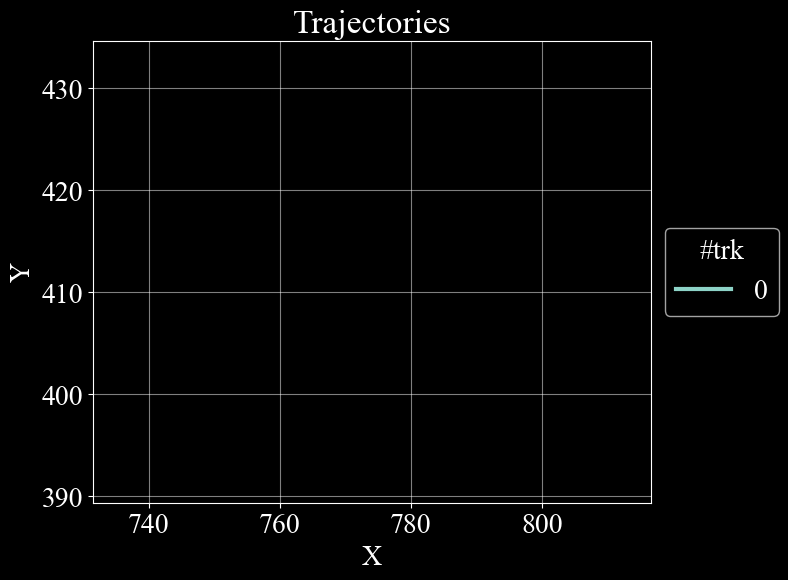

In [35]:
# trajectories

fig = plt.figure
ax = plt.subplot(111)

for k, v in ltrk.trackers.items():
    ax.plot(v.get_data('x'), fheight - v.get_data('y'), linewidth = 3, label = str(k))

plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'X',ylabel = 'Y')
ax.set_title('Trajectories')
ax.grid(alpha = 0.5)
plt.show() 

